In [1]:
import pandas as pd
import numpy as np
from tensorboardX import SummaryWriter
from helper import plot_results, predict, train, split_data

In [2]:
writer = SummaryWriter('runs/profiler')

In [3]:
df = pd.read_csv("https://query1.finance.yahoo.com/v7/finance/download/MSFT?period1=1458000000&period2=1915766400&interval=1d&events=history&includeAdjustedClose=true", parse_dates=True)

In [4]:
# TODO run this in the demo
df = df[['Date','Close']]

In [5]:
# Plot data
import plotly.express as px

fig = px.line(df, x='Date', y='Close', title='Time Series with Range Slider and Selectors')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()

## Data Cleaning / Preprocessing

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))

def preprocess_data(df):
    df_msft = df[['Close']]
    df_msft = df_msft.fillna(method='ffill')
    df_msft['Close'] = scaler.fit_transform(df_msft['Close'].values.reshape(-1,1))
    return df_msft

df_msft = preprocess_data(df)

In [7]:
import torch
import torch.nn as nn

lookback = 100
x_train, y_train, x_test, y_test = split_data(df_msft, lookback)

In [8]:
# Model params
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 5

## Use GPU if available

In [9]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)

In [10]:
x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

## LSTM Model

In [11]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [12]:
model_lstm = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

# writer.add_graph(model_lstm, x_train.to("cpu"))
model_lstm.to(device)

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

### LSTM Training

In [13]:
train(num_epochs, model_lstm, x_train.to(device), y_train, writer, 'LSTM Training Loss')

Epoch  0 MSE:  0.29944050312042236
Epoch  1 MSE:  0.17968861758708954
Epoch  2 MSE:  0.09036418795585632
Epoch  3 MSE:  0.24680055677890778
Epoch  4 MSE:  0.09789250791072845
Epoch  5 MSE:  0.08444381505250931
Epoch  6 MSE:  0.10100529342889786
Epoch  7 MSE:  0.11193078756332397
Epoch  8 MSE:  0.11237014830112457
Epoch  9 MSE:  0.10332749783992767
Epoch  10 MSE:  0.08684953302145004
Epoch  11 MSE:  0.06627728044986725
Epoch  12 MSE:  0.04960629343986511
Epoch  13 MSE:  0.0552002377808094
Epoch  14 MSE:  0.06603075563907623
Epoch  15 MSE:  0.04643648490309715
Epoch  16 MSE:  0.033302877098321915
Epoch  17 MSE:  0.03173656016588211
Epoch  18 MSE:  0.03309374675154686
Epoch  19 MSE:  0.03154834359884262
Epoch  20 MSE:  0.02439487911760807
Epoch  21 MSE:  0.012239709496498108
Epoch  22 MSE:  0.003582603996619582
Epoch  23 MSE:  0.013642173260450363
Epoch  24 MSE:  0.012358116917312145
Epoch  25 MSE:  0.005547149106860161
Epoch  26 MSE:  0.009307686239480972
Epoch  27 MSE:  0.01125087589025

### LSTM Prediction

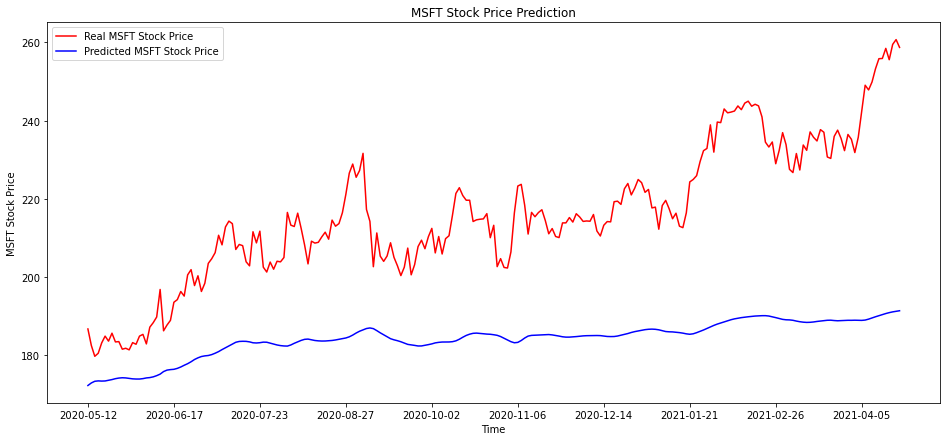

In [14]:
y_test_lstm, y_test_pred_lstm = predict(model_lstm, x_test, y_test, scaler)

plt, figure = plot_results(y_test_lstm, y_test_pred_lstm, df)

plt.show()

## GRU Model

In [15]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [16]:
model_gru = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

# writer.add_graph(model_gru, x_train)

model_gru.to(device)

GRU(
  (gru): GRU(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

### GRU Training

In [17]:
train(num_epochs, model_gru, x_train, y_train, writer, 'GRU Training Loss')

Epoch  0 MSE:  0.3151332139968872
Epoch  1 MSE:  0.12739335000514984
Epoch  2 MSE:  0.09163950383663177
Epoch  3 MSE:  0.11224449425935745
Epoch  4 MSE:  0.07254213094711304
Epoch  5 MSE:  0.058935996145009995
Epoch  6 MSE:  0.06375021487474442
Epoch  7 MSE:  0.05875282362103462
Epoch  8 MSE:  0.04012085124850273
Epoch  9 MSE:  0.021487964317202568
Epoch  10 MSE:  0.01809483766555786
Epoch  11 MSE:  0.02050759084522724
Epoch  12 MSE:  0.009197789244353771
Epoch  13 MSE:  0.0019423143239691854
Epoch  14 MSE:  0.014386415481567383
Epoch  15 MSE:  0.017056521028280258
Epoch  16 MSE:  0.0070969704538583755
Epoch  17 MSE:  0.002146253129467368
Epoch  18 MSE:  0.004040237050503492
Epoch  19 MSE:  0.004946168977767229
Epoch  20 MSE:  0.0033278875052928925
Epoch  21 MSE:  0.0027456143870949745
Epoch  22 MSE:  0.0041990396566689014
Epoch  23 MSE:  0.005694172345101833
Epoch  24 MSE:  0.0054915901273489
Epoch  25 MSE:  0.003782053478062153
Epoch  26 MSE:  0.00216325162909925
Epoch  27 MSE:  0.00

### GRU Prediction

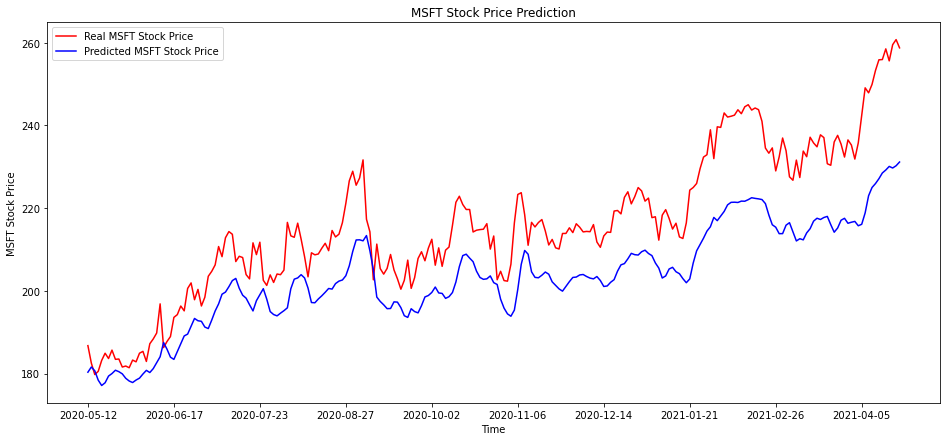

In [18]:
y_test_gru, y_test_pred_gru = predict(model_gru, x_test, y_test, scaler)

plt, figure = plot_results(y_test_gru, y_test_pred_gru, df)

plt.show()

## Cleanup

In [19]:
writer.close()